In [1]:
from my_transformer import MyTransformer
import pandas as pd

# label
label_feature = 'Danceability'

# features
dont_transform_features = ['Energy', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence']
normal_transform_features = ['Tempo']
power_transform_features = ['Loudness', 'Duration_ms', 'Stream', 'Views', 'Likes', 'Comments']
categorical_features = ['Album_type', 'Key', 'Licensed', 'official_video']

# all features
features_columns = dont_transform_features + normal_transform_features + power_transform_features + categorical_features
label_column = label_feature

# import data
train_df = pd.read_csv('data/train.csv')[features_columns + [label_column]]
test_df = pd.read_csv('data/test.csv')[features_columns]
test_ids = pd.read_csv('data/test.csv')['id']

# init transformer
my_transformer = MyTransformer(
    all_features=features_columns,
    categorical_features=categorical_features,
    normal_transform_features=normal_transform_features,
    power_transform_features=power_transform_features,
    label_column=label_column,
)

# transform dataset
_ = my_transformer.features_fit_transform(train_df)
train_df = my_transformer.features_transform(train_df)
test_df = my_transformer.features_transform(test_df)
train_X, train_Y = train_df.drop(columns=[label_column]), train_df[label_column]
test_X = test_df

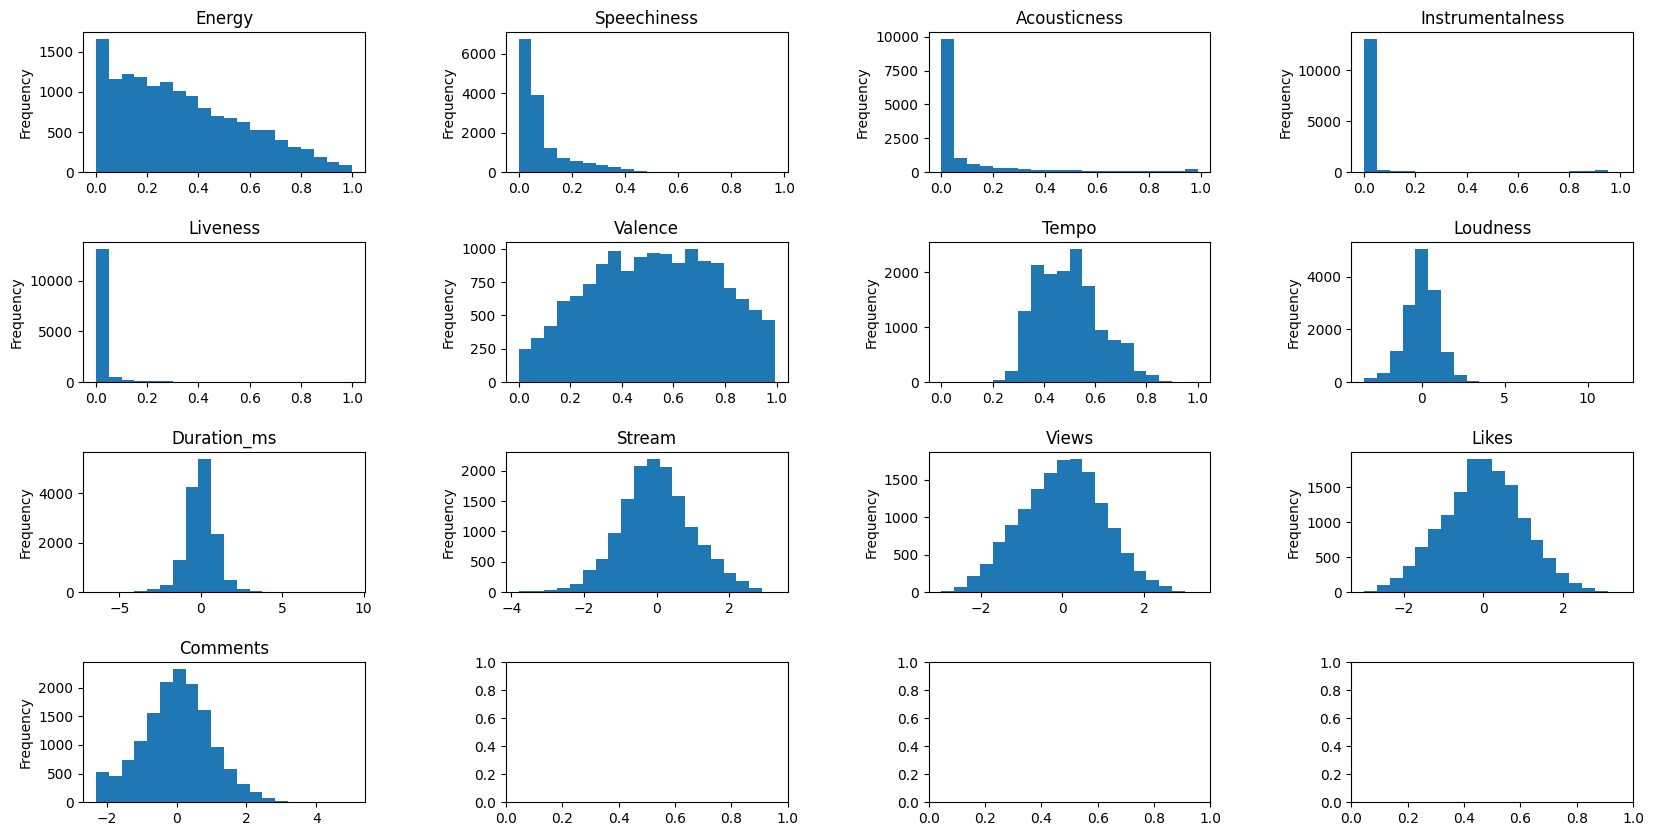

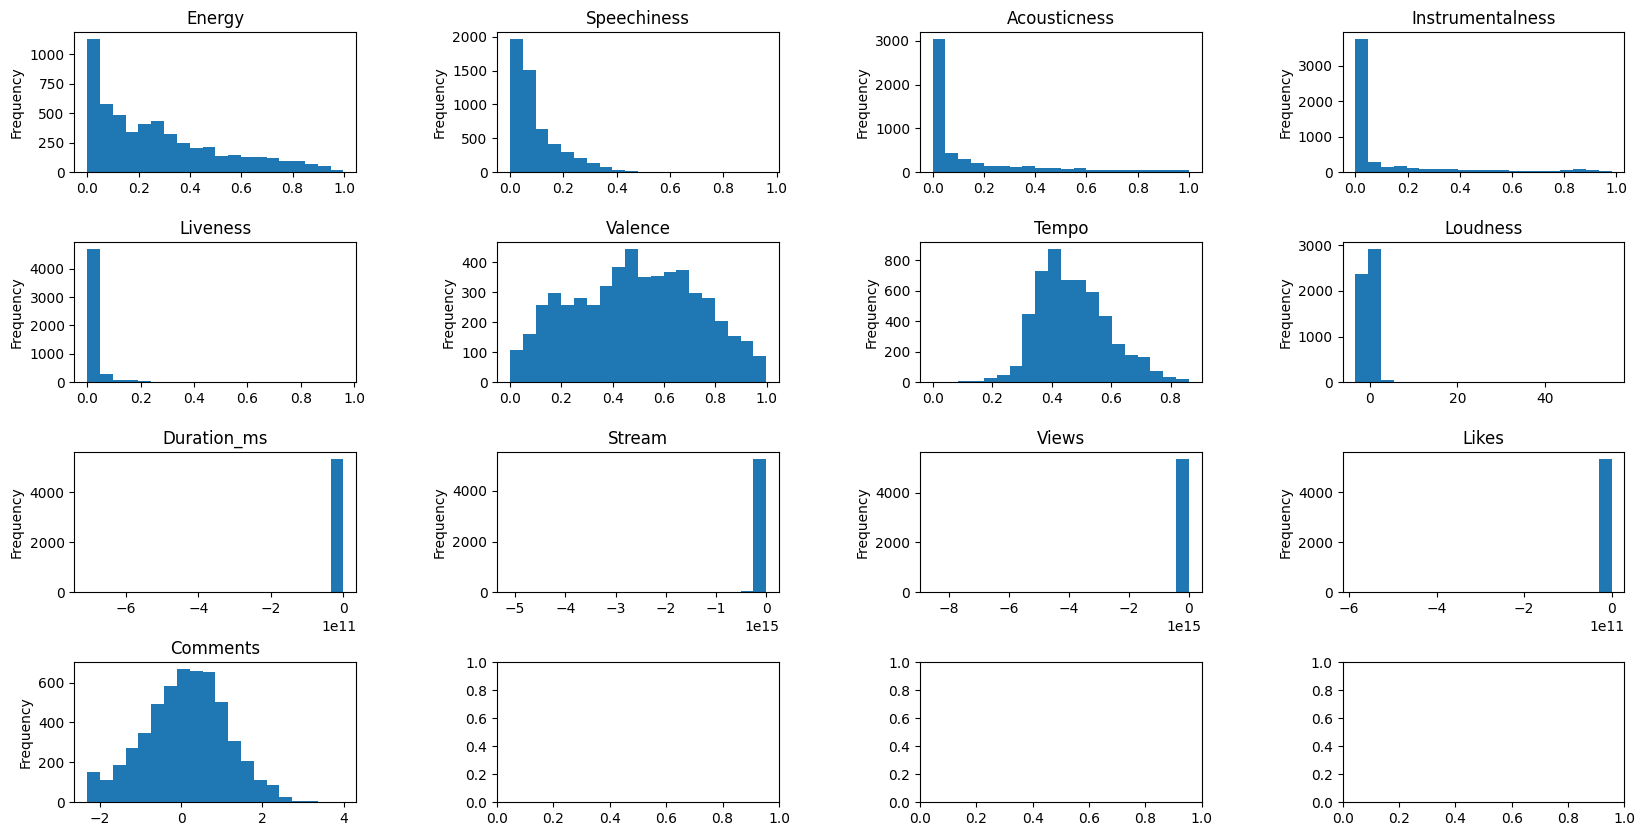

In [2]:
from utils import plot_distribution

plot_distribution(train_X, dont_transform_features + normal_transform_features + power_transform_features)
plot_distribution(test_X, dont_transform_features + normal_transform_features + power_transform_features)
